In [1]:
# 1) Imports & data loading

import polars as pl
df = pl.read_csv("train_processed.csv").to_pandas()



In [ ]:
# 2) Prepare X, y
X = df.drop(columns=["SK_ID_CURR", "TARGET"])
y = df["TARGET"].astype(int)

# 3) One‐hot encode categoricals
import pandas as pd  
X = pd.get_dummies(X, dummy_na=True)

# 4) Train/Test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
)

In [ ]:
# 5) Model definitions
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

models = {
    "LightGBM": LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        random_state=42
    ),
    "CatBoost": CatBoostClassifier(
        iterations=1000,
        # learning_rate=0.05, # let CatBoost determine learning rate
        eval_metric="AUC",
        verbose=0,
        random_seed=42
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )
}

In [ ]:
# 6) Train & Evaluate
from sklearn.metrics import roc_auc_score

results = {}
for name, model in models.items():
    print(f"\n>>> Training {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    results[name] = auc
    print(f"{name} ROC AUC: {auc:.4f}")

# 7) Summary
print("\n=== All model ROC AUC scores ===")
for name, auc in results.items():
    print(f"• {name.ljust(12)}: {auc:.4f}")


>>> Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6366
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
LightGBM ROC AUC: 0.7690

>>> Training CatBoost...
CatBoost ROC AUC: 0.7708

>>> Training RandomForest...
RandomForest ROC AUC: 0.7411

=== All model ROC AUC scores ===
• LightGBM    : 0.7690
• CatBoost    : 0.7708
• RandomForest: 0.7411


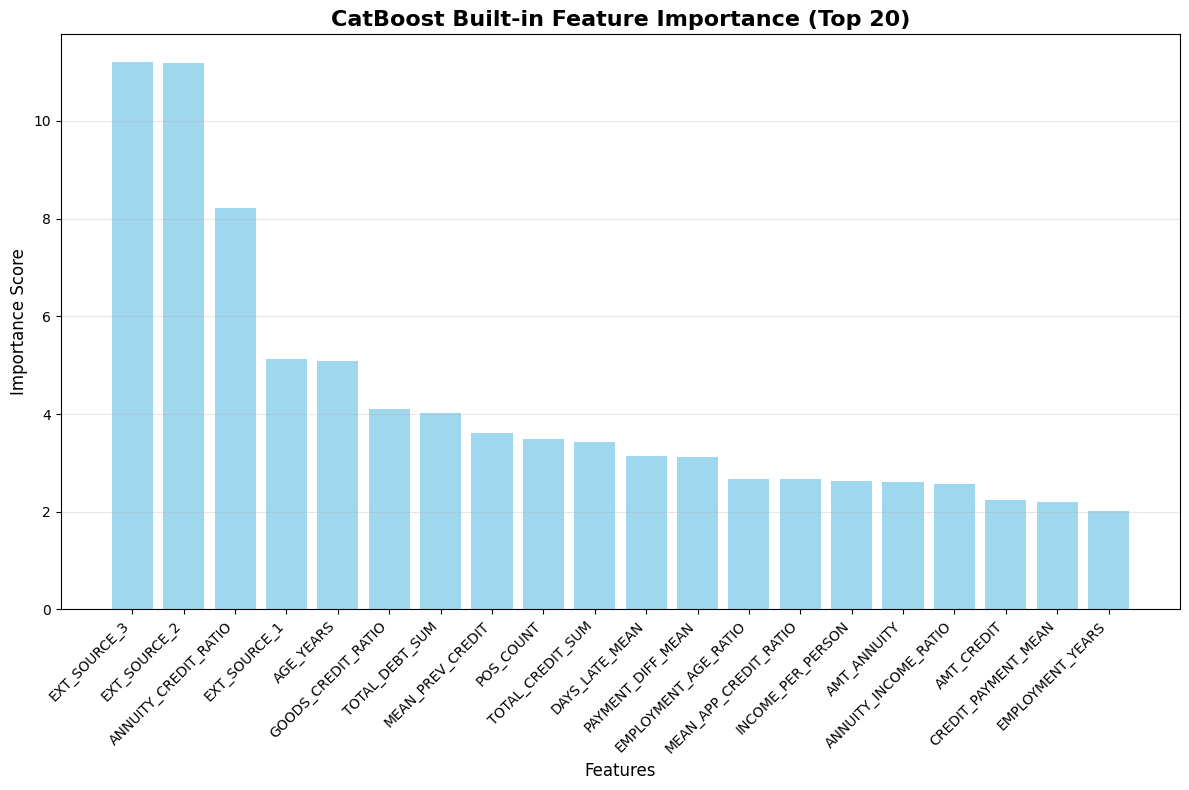

Top 10 Most Important Features (CatBoost Built-in):
 1. EXT_SOURCE_3                   : 11.2127
 2. EXT_SOURCE_2                   : 11.1954
 3. ANNUITY_CREDIT_RATIO           : 8.2181
 4. EXT_SOURCE_1                   : 5.1313
 5. AGE_YEARS                      : 5.0827
 6. GOODS_CREDIT_RATIO             : 4.0967
 7. TOTAL_DEBT_SUM                 : 4.0236
 8. MEAN_PREV_CREDIT               : 3.6219
 9. POS_COUNT                      : 3.4918
10. TOTAL_CREDIT_SUM               : 3.4226


In [30]:
# Built-in CatBoost Feature Importance Analysis
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance from the trained CatBoost model
feature_importance = model.feature_importances_
feature_names = X_train.columns

# Sort features by importance
importance_indices = np.argsort(feature_importance)[::-1]
sorted_importance = feature_importance[importance_indices]
sorted_names = feature_names[importance_indices]

# Plot top 20 most important features
plt.figure(figsize=(12, 8))
top_n = 20
plt.bar(range(top_n), sorted_importance[:top_n], alpha=0.8, color='skyblue')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance Score', fontsize=12)
plt.title('CatBoost Built-in Feature Importance (Top 20)', fontsize=16, fontweight='bold')
plt.xticks(range(top_n), [name for name in sorted_names[:top_n]], 
           rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print top 10 features with their importance scores
print("Top 10 Most Important Features (CatBoost Built-in):")
print("=" * 50)
for i in range(10):
    print(f"{i+1:2d}. {sorted_names[i]:<30} : {sorted_importance[i]:.4f}")